# Puzzle

https://thefiddler.substack.com/p/lets-make-a-tic-tac-deal

**This Week’s Fiddler**

From Nicholas Smith comes a puzzle about a modified version of tic-tac-toe:

The game of Tic-Tac-Deal 2.0 has a 3-by-3 square grid with the numbers 3 through 11, arranged as follows:

    3  4  5
    6  7  8
    9 10 11

You start by rolling a standard pair of six-sided dice and add the two numbers rolled. You place an X on the board on the square that contains the sum. If the sum is a 2 or 12, or if you roll a sum that you have previously rolled, then your roll is wasted.

If you have exactly three rolls of the dice, what are your chances of getting three Xs in a row (either horizontally, vertically, or diagonally)?

**This Week’s Extra Credit**

In the actual game, you get five rolls instead of three. But as before, rolling a 2, a 12, or a number that you have already rolled is a wasted turn.

With five rolls of the dice, what are your chances of getting three Xs in a row, either horizontally, vertically, or diagonally?

# Solution
Seems like a straightforward issue to enumerate all 8 three-Xs-in-a-row cases and calculate the probabilities. I am going to use some code because it seems a bit tedious to do by hand.

BREAKING NEWS: UPDATE: This is not straightforward at all -- this question quickly exposes any muddled thinking about probabilities. :)

In [125]:
from functools import cache
from fractions import Fraction as F
from itertools import combinations, product

@cache
def ways_value_from_roll(roll, num_dice=2, num_sides=6):
    """Calculate the ways of rolling a specific value with a given number of dice and sides."""
    if roll < num_dice or roll > num_dice * num_sides:
        return 0
    if num_dice == 1:
        return 1
    
    ways = 0
    for first_die in range(1, num_sides + 1):
        ways += ways_value_from_roll(roll - first_die, num_dice - 1, num_sides)

    return ways

@cache
def prob_value_from_roll(roll, num_dice=2, num_sides=6):
    """Calculate the probability of rolling a specific value with a given number of dice and sides."""
    total_ways = num_sides ** num_dice
    successful_ways = ways_value_from_roll(roll, num_dice, num_sides)
    p = F(successful_ways, total_ways)
    return p

assert prob_value_from_roll(3, 2, 6) == F(2, 36)

In [126]:
# Slow, but useful as a crosscheck.
def prob_group_exhaustive(values, num_rolls=3, num_dice=2, num_sides=6):
    """Calculate the probability of rolling all of the specified values in a given number of rolls."""
    if len(values) > num_rolls:
        return F(0)
    if not values:
        return F(1)
     
    p = F(0)
    for run in product(range(num_dice, num_dice * num_sides + 1), repeat=num_rolls):
        contains_all = all(val in run for val in values)
        if contains_all:
            p_run = F(1)
            for r in run:
                p_run *= prob_value_from_roll(r, num_dice, num_sides)
            p += p_run

    assert 0 <= p <= 1, f"Probability out of bounds: {p}"

    return p
assert(prob_group_exhaustive([3, 4, 5], 3, 2, 6) == F(2*3*4*6, 36*36*36))

In [127]:
# Faster, esp because of the caching.
@cache
def prob_group_elem_mask(elem_mask, num_rolls=3, num_dice=2, num_sides=6):
    """Calculate the probability of rolling all of the specified values in a given number of rolls."""
    if elem_mask == 0:
        return F(1)
    if num_rolls == 0:
        return F(0)
    
    p, deferred_p = F(0), F(0)
    for r in range(num_dice, num_dice * num_sides + 1):
        r_mask = 1 << r
        p_r = prob_value_from_roll(r, num_dice, num_sides)
        if (elem_mask & r_mask) != 0:
            p_rest = prob_group_elem_mask(elem_mask ^ r_mask, num_rolls - 1, num_dice, num_sides)
            p += p_r * p_rest
        else:
            deferred_p += p_r
    p += deferred_p * prob_group_elem_mask(elem_mask, num_rolls - 1, num_dice, num_sides)
    return p
    
def prob_group(values, num_rolls=3, num_dice=2, num_sides=6):
    """Calculate the probability of rolling all of the specified values in a given number of rolls."""
    elem_mask = sum(1 << v for v in values)
    return prob_group_elem_mask(elem_mask, num_rolls, num_dice, num_sides)

assert prob_group([3, 4, 5], 3, 2, 6) == F(2*3*4*6, 36*36*36)

In [128]:
def prob_three_in_a_row(num_rolls=3, num_dice=2, num_sides=6, debug=False, prob_group_func=prob_group):
    """Calculate the probability of rolling three tic-tac-toe-in-a-row values in a given number of rolls."""
    winning_combinations = [
        [3, 4, 5], [6, 7, 8], [9, 10, 11],  # Horizontal
        [3, 6, 9], [4, 7, 10], [5, 8, 11],  # Vertical
        [3, 7, 11], [5, 7, 9]               # Diagonal
    ]
    
    total_probability = F(0)

    # Full on PIE (Principle of Inclusion-Exclusion)
    for r in range(1, len(winning_combinations) + 1):
        for comb_comb in combinations(winning_combinations, r):
            combined_values = set()
            for lst in comb_comb:
                combined_values.update(lst)
            p = prob_group_func(list(combined_values), num_rolls, num_dice, num_sides)
            if r % 2 == 1:
                total_probability += p
            else:
                total_probability -= p
            if debug and p > 0:
                print(f"Combination: {comb_comb}, Combined Values: {combined_values}, Probability: {float(p):.6f}, total_probability: {float(total_probability):.6f}")
    
    return total_probability

In [129]:
Fiddler_Answer = prob_three_in_a_row(3, 2, 6)
Fiddler_Answer_Exhaustive = prob_three_in_a_row(3, 2, 6, prob_group_func=prob_group_exhaustive)
assert Fiddler_Answer == Fiddler_Answer_Exhaustive
print(f"Fiddler's Answer: {Fiddler_Answer} or approximately {float(Fiddler_Answer):.6f}")

Extra_Credit_Answer = prob_three_in_a_row(5, 2, 6)
Extra_Credit_Answer_Exhaustive = prob_three_in_a_row(5, 2, 6, prob_group_func=prob_group_exhaustive)
assert Extra_Credit_Answer == Extra_Credit_Answer_Exhaustive
print(f"Extra Credit Answer: {Extra_Credit_Answer} or approximately {float(Extra_Credit_Answer):.6f}")


Fiddler's Answer: 113/1944 or approximately 0.058128
Extra Credit Answer: 910405/2519424 or approximately 0.361354


# Explorations.

**Plotting the probability of getting three in a row vs number of rolls**

Rolls: 0, Probability: 0 or approximately 0.000000
Rolls: 1, Probability: 0 or approximately 0.000000
Rolls: 2, Probability: 0 or approximately 0.000000
Rolls: 3, Probability: 113/1944 or approximately 0.058128
Rolls: 4, Probability: 3325/17496 or approximately 0.190043
Rolls: 5, Probability: 910405/2519424 or approximately 0.361354
Rolls: 6, Probability: 23929075/45349632 or approximately 0.527658
Rolls: 7, Probability: 80482969/120932352 or approximately 0.665521
Rolls: 8, Probability: 1256747485/1632586752 or approximately 0.769789
Rolls: 9, Probability: 3573073000505/4231664861184 or approximately 0.844366
Rolls: 10, Probability: 68239437568925/76169967501312 or approximately 0.895884
Rolls: 11, Probability: 5104259845554463/5484237660094464 or approximately 0.930715
Rolls: 12, Probability: 47085860434140935/49358138940850176 or approximately 0.953963
Rolls: 13, Probability: 2296636082142773735/2369190669160808448 or approximately 0.969376
Rolls: 14, Probability: 417740198700140293

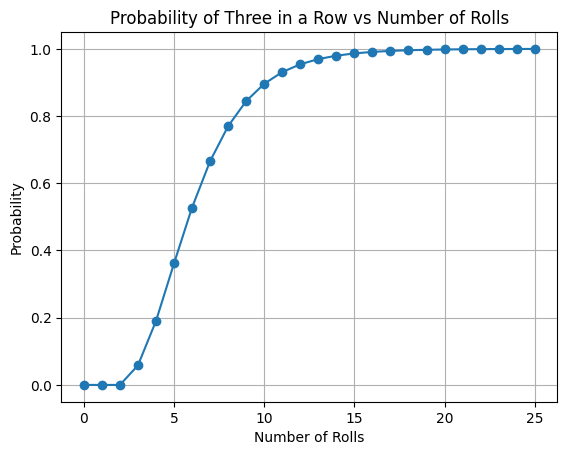

In [130]:
from matplotlib import pyplot as plt

rolls = list(range(0, 26))
probabilities_2_6 = [prob_three_in_a_row(roll, 2, 6) for roll in rolls]

for i, p in zip(rolls, probabilities_2_6):
    print(f"Rolls: {i}, Probability: {p} or approximately {float(p):.6f}")

plt.plot(rolls, probabilities_2_6, marker='o')
plt.title("Probability of Three in a Row vs Number of Rolls")
plt.xlabel("Number of Rolls")
plt.ylabel("Probability")
plt.grid()
plt.show()

**What if we used 2 7-sided dice instead of 2 6-sided dice?**

Rolls: 0, Probability: 0 or approximately 0.000000
Rolls: 1, Probability: 0 or approximately 0.000000
Rolls: 2, Probability: 0 or approximately 0.000000
Rolls: 3, Probability: 4848/117649 or approximately 0.041207
Rolls: 4, Probability: 801456/5764801 or approximately 0.139026
Rolls: 5, Probability: 78085080/282475249 or approximately 0.276432
Rolls: 6, Probability: 5868579000/13841287201 or approximately 0.423991
Rolls: 7, Probability: 54228715824/96889010407 or approximately 0.559699
Rolls: 8, Probability: 3195613022688/4747561509943 or approximately 0.673106
Rolls: 9, Probability: 1241162486919240/1628413597910449 or approximately 0.762191
Rolls: 10, Probability: 66176460651597000/79792266297612001 or approximately 0.829359
Rolls: 11, Probability: 3435286847649833088/3909821048582988049 or approximately 0.878630
Rolls: 12, Probability: 175127523645172278576/191581231380566414401 or approximately 0.914116
Rolls: 13, Probability: 1259761215490764285000/1341068619663964900807 or approx

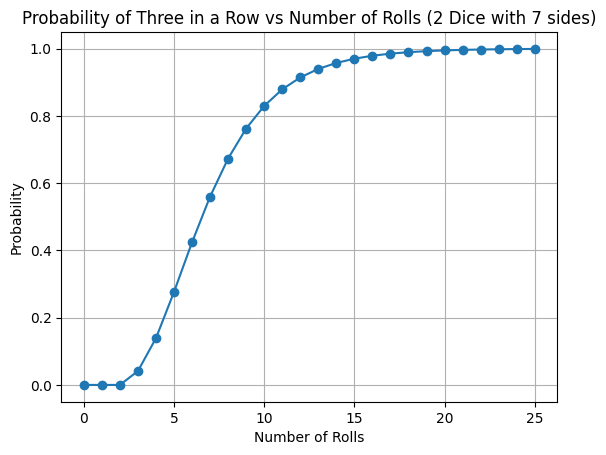

In [131]:
probabilities_2_7 = [prob_three_in_a_row(roll, 2, 7) for roll in rolls]

for i, p in zip(rolls, probabilities_2_7):
    print(f"Rolls: {i}, Probability: {p} or approximately {float(p):.6f}")

plt.plot(rolls, probabilities_2_7, marker='o')
plt.title("Probability of Three in a Row vs Number of Rolls (2 Dice with 7 sides)")
plt.xlabel("Number of Rolls")
plt.ylabel("Probability")
plt.grid()
plt.show()

**What if we used 3 6-sided dice instead of 2 6-sided dice?**

Rolls: 0, Probability: 0 or approximately 0.000000
Rolls: 1, Probability: 0 or approximately 0.000000
Rolls: 2, Probability: 0 or approximately 0.000000
Rolls: 3, Probability: 28915/1679616 or approximately 0.017215
Rolls: 4, Probability: 390301/6718464 or approximately 0.058094
Rolls: 5, Probability: 9490978055/78364164096 or approximately 0.121114
Rolls: 6, Probability: 188419238395/940369969152 or approximately 0.200367
Rolls: 7, Probability: 351755015445365/1218719480020992 or approximately 0.288627
Rolls: 8, Probability: 49920764141776409/131621703842267136 or approximately 0.379275
Rolls: 9, Probability: 79693195524103305415/170581728179578208256 or approximately 0.467185
Rolls: 10, Probability: 1123599725177629316315/2046980738154938499072 or approximately 0.548906
Rolls: 11, Probability: 4954031358137177547736175/7958661109946400884391936 or approximately 0.622470
Rolls: 12, Probability: 65617265904778788460920803/95503933319356810612703232 or approximately 0.687063
Rolls: 13, 

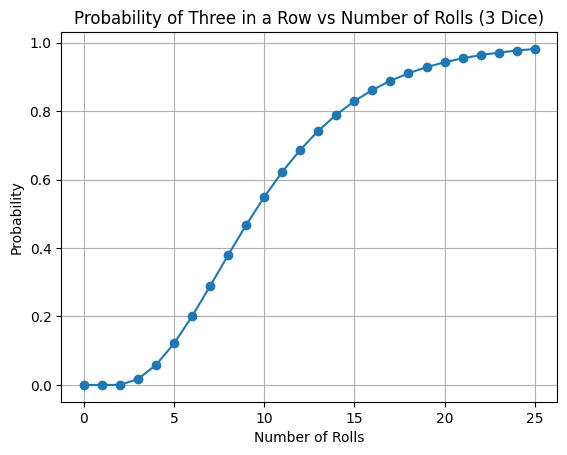

In [132]:

probabilities_3_6 = [prob_three_in_a_row(roll, 3, 6) for roll in rolls]

for i, p in zip(rolls, probabilities_3_6):
    print(f"Rolls: {i}, Probability: {p} or approximately {float(p):.6f}")

plt.plot(rolls, probabilities_3_6, marker='o')
plt.title("Probability of Three in a Row vs Number of Rolls (3 Dice)")
plt.xlabel("Number of Rolls")
plt.ylabel("Probability")
plt.grid()
plt.show()

# Conclusion

**Fiddler's Answer: 113/1944 or approximately 0.058128**

**Extra Credit Answer: 910405/2519424 or approximately 0.361354**

I thought this was straightforward, but it turned out to be much trickier than that, and it took a lot of time to get everything straight.

The explorations were invaluable in exposing more bugs in the code.

Cautiously optimistic that this is bug-free now.

---

Regarding prob_group, I took a recursive approach, but it may be possible to take an inclusion-exclusion approach and solve it that way too. That might be more efficient for small list of values + large number of rolls (e.g. prob of rolling a 3-4-5 in 100 rolls), but I have not thought it through fully.

Another realization - I used recursion-by-roll at the group (triplet) level and then inclusion-exclusion at the whole board level. It may be simpler to just use recursion-by-roll at the whole board level. But I am not motivated to redo and redebug my code at this point.